In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ta
import optuna

sns.set_theme()

## Backtest

In [2]:
"""data = pd.read_csv('aapl_5m_train.csv').dropna()
data"""

"data = pd.read_csv('aapl_5m_train.csv').dropna()\ndata"

In [3]:
data = pd.read_csv('Binance_BTCUSDT_1h.csv').dropna()
data = data.rename(columns={'Date': 'Datetime'})
data['Datetime'] = pd.to_datetime(data['Datetime'], errors='coerce', dayfirst=True)
data = data.iloc[::-1].reset_index(drop=True)
data

/var/folders/z2/hrkxn9jx30j3lk9_pr6zzywr0000gn/T/ipykernel_10907/3715450329.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Datetime'] = pd.to_datetime(data['Datetime'], errors='coerce', dayfirst=True)


,Unix,Datetime,Symbol,Open,High,Low,Close,Volume BTC,Volume USDT,tradecount
0,1.502940e+12,2017-08-17 04:00:00,BTCUSDT,4261.48,4313.62,4261.32,4308.83,47.181009,2.023661e+05,171
1,1.502950e+12,2017-08-17 05:00:00,BTCUSDT,4308.83,4328.69,4291.37,4315.32,23.234916,1.003048e+05,102
2,1.502950e+12,2017-08-17 06:00:00,BTCUSDT,4330.29,4345.45,4309.37,4324.35,7.229691,3.128231e+04,36
3,1.502950e+12,2017-08-17 07:00:00,BTCUSDT,4316.62,4349.99,4287.41,4349.99,4.443249,1.924106e+04,25
4,1.502960e+12,2017-08-17 08:00:00,BTCUSDT,4333.32,4377.85,4333.32,4360.69,0.972807,4.239504e+03,28
...,...,...,...,...,...,...,...,...,...,...
70822,1.758570e+12,2025-09-22 19:00:00,BTCUSDT,112429.12,112600.87,111936.40,112122.90,1307.373650,1.467768e+08,126232
70823,1.758570e+12,2025-09-22 20:00:00,BTCUSDT,112122.90,112977.41,111975.28,112781.88,596.840050,6.707508e+07,93553
70824,1.758570e+12,2025-09-22 21:00:00,BTCUSDT,112781.87,112970.00,112602.79,112969.99,293.311560,3.307493e+07,42931
70825,1.758580e+12,2025-09-22 22:00:00,BTCUSDT,112969.99,112970.00,112594.33,112643.25,289.607150,3.264691e+07,42836


In [4]:
from dataclasses import dataclass

@dataclass
class Operation:
    time: str
    price: float
    stop_loss: float
    take_profit: float
    n_shares: int
    type: str

In [5]:
def get_portfolio_value(cash: float, long_ops: list[Operation], short_ops: list[Operation], current_price:float, n_shares: int, COM: float) -> float:
    val = cash

    # Add long positions value
    val += len(long_ops) * current_price * n_shares * (1 - COM)

    # Add short positions value
    for pos in short_ops:
        pnl = (pos.price - current_price) * pos.n_shares * (1 - COM)

        val += pnl

    return val

### Optimización de hiperparámetros

In [6]:
def backtest(data, trial) -> float:
    data = data.copy()

    rsi_window = trial.suggest_int('rsi_window', 5, 50)
    rsi_lower = trial.suggest_int('rsi_lower', 5, 35)
    rsi_upper = trial.suggest_int('rsi_upper', 65, 95)
    stop_loss = trial.suggest_float('stop_loss', 0.01, 0.15)
    take_profit = trial.suggest_float('take_profit', 0.01, 0.15)
    n_shares = trial.suggest_int('n_shares', 50, 500)

    rsi_indicator = ta.momentum.RSIIndicator(data.Close, window=rsi_window)
    data['rsi'] = rsi_indicator.rsi()

    historic = data.copy()
    historic = historic.dropna()
    historic['buy_signal'] = historic.rsi < rsi_lower
    historic['sell_signal'] = historic.rsi > rsi_upper

    COM = 0.125 / 100
    SL = stop_loss
    TP = take_profit
    n_shares = n_shares

    active_long_positions: list[Operation] = []
    active_short_positions: list[Operation] = []

    cash = 1_000_000

    portfolio_value = []

    for i, row in historic.iterrows():
        # Close long positions
        for position in active_long_positions.copy():
            if row.Close > position.take_profit or row.Close < position.stop_loss:
                cash += row.Close * position.n_shares * (1 - COM)
                active_long_positions.remove(position)

        # Close short positions
        for position in active_short_positions.copy():
            if row.Close < position.take_profit or row.Close > position.stop_loss:
                cover_cost = row.Close * position.n_shares * (1 + COM)
                initial_sell = position.price * position.n_shares
                pnl = initial_sell - cover_cost
                cash += pnl
                active_short_positions.remove(position)
                continue

        # --- BUY ---
        # Check signal
        if row.buy_signal:
            # Do we have enough cash?
            if cash > row.Close * n_shares * (1 + COM):
                # Discount the cost
                cash -= row.Close * n_shares * (1 + COM)
                # Save the operation as active position
                active_long_positions.append(
                    Operation(
                    time=row.Datetime,
                    price=row.Close,
                    take_profit=row.Close * (1 + TP),
                    stop_loss=row.Close * (1 - SL),
                    n_shares=n_shares,
                    type="LONG"
                    )
                )

        # --- SELL ---
        # Check signal
        if row.sell_signal:
            # Do we have enough cash?
            position_value = row.Close * n_shares * (1 + COM)
            if cash > position_value:
                cash -= position_value
                active_short_positions.append(
                    Operation(
                    time=row.Datetime,
                    price=row.Close,
                    take_profit=row.Close * (1 - TP),
                    stop_loss=row.Close * (1 + SL),
                    n_shares=n_shares,
                    type="SHORT"
                    )
                )
                
        portfolio_value.append(get_portfolio_value(cash, active_long_positions, active_short_positions, row.Close, n_shares, COM))

    # Close long positions        
    cash += row.Close * len(active_long_positions) * n_shares * (1 - COM)

    # Close short positions
    for position in active_short_positions:
        cover_cost = row.Close * position.n_shares * (1 + COM)
        initial_sell = position.price * position.n_shares
        pnl = initial_sell - cover_cost
        cash += pnl
    
    active_long_positions = []
    active_short_positions = []

    return (cash / 1_000_000) - 1

In [7]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: backtest(data, trial), n_trials=10, n_jobs=-1)

[I 2025-10-03 14:56:49,923] A new study created in memory with name: no-name-54da1088-923d-4eb2-9fa5-b93c06be0391
[I 2025-10-03 14:56:58,409] Trial 3 finished with value: -0.814810694775 and parameters: {'rsi_window': 24, 'rsi_lower': 9, 'rsi_upper': 81, 'stop_loss': 0.038162605396307676, 'take_profit': 0.06542194652138802, 'n_shares': 109}. Best is trial 3 with value: -0.814810694775.
[I 2025-10-03 14:56:58,535] Trial 2 finished with value: -0.8579658696 and parameters: {'rsi_window': 31, 'rsi_lower': 17, 'rsi_upper': 77, 'stop_loss': 0.0267586783270953, 'take_profit': 0.06946595071126359, 'n_shares': 224}. Best is trial 3 with value: -0.814810694775.
[I 2025-10-03 14:56:58,664] Trial 1 finished with value: -1.0939275709749998 and parameters: {'rsi_window': 28, 'rsi_lower': 12, 'rsi_upper': 73, 'stop_loss': 0.09613653327547861, 'take_profit': 0.03380885866873753, 'n_shares': 278}. Best is trial 3 with value: -0.814810694775.
[I 2025-10-03 14:56:58,859] Trial 7 finished with value: 0.0

In [8]:
study.best_params

{'rsi_window': 39,
 'rsi_lower': 17,
 'rsi_upper': 78,
 'stop_loss': 0.06734061184371147,
 'take_profit': 0.11447191654100558,
 'n_shares': 411}

In [9]:
study.best_value

0.0

### Usando parámetros óptimos

In [10]:
window = study.best_params['rsi_window']
lower = study.best_params['rsi_lower']
upper = study.best_params['rsi_upper']
SL = study.best_params['stop_loss']
TP = study.best_params['take_profit']
n_shares = study.best_params['n_shares']

COM = 0.125 / 100
cash = 1_000_000

In [11]:
#data = pd.read_csv('aapl_5m_train.csv').dropna()
#data

In [12]:
data = pd.read_csv('Binance_BTCUSDT_1h.csv').dropna()
data = data.rename(columns={'Date': 'Datetime'})
data['Datetime'] = pd.to_datetime(data['Datetime'], errors='coerce', dayfirst=True)
data = data.iloc[::-1].reset_index(drop=True)
data

/var/folders/z2/hrkxn9jx30j3lk9_pr6zzywr0000gn/T/ipykernel_10907/3715450329.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Datetime'] = pd.to_datetime(data['Datetime'], errors='coerce', dayfirst=True)


,Unix,Datetime,Symbol,Open,High,Low,Close,Volume BTC,Volume USDT,tradecount
0,1.502940e+12,2017-08-17 04:00:00,BTCUSDT,4261.48,4313.62,4261.32,4308.83,47.181009,2.023661e+05,171
1,1.502950e+12,2017-08-17 05:00:00,BTCUSDT,4308.83,4328.69,4291.37,4315.32,23.234916,1.003048e+05,102
2,1.502950e+12,2017-08-17 06:00:00,BTCUSDT,4330.29,4345.45,4309.37,4324.35,7.229691,3.128231e+04,36
3,1.502950e+12,2017-08-17 07:00:00,BTCUSDT,4316.62,4349.99,4287.41,4349.99,4.443249,1.924106e+04,25
4,1.502960e+12,2017-08-17 08:00:00,BTCUSDT,4333.32,4377.85,4333.32,4360.69,0.972807,4.239504e+03,28
...,...,...,...,...,...,...,...,...,...,...
70822,1.758570e+12,2025-09-22 19:00:00,BTCUSDT,112429.12,112600.87,111936.40,112122.90,1307.373650,1.467768e+08,126232
70823,1.758570e+12,2025-09-22 20:00:00,BTCUSDT,112122.90,112977.41,111975.28,112781.88,596.840050,6.707508e+07,93553
70824,1.758570e+12,2025-09-22 21:00:00,BTCUSDT,112781.87,112970.00,112602.79,112969.99,293.311560,3.307493e+07,42931
70825,1.758580e+12,2025-09-22 22:00:00,BTCUSDT,112969.99,112970.00,112594.33,112643.25,289.607150,3.264691e+07,42836


In [13]:
rsi_indicator = ta.momentum.RSIIndicator(data.Close, window=window)
data['rsi'] = rsi_indicator.rsi()

In [14]:
historic = data.copy()
historic['buy_signal'] = historic.rsi < lower
historic['sell_signal'] = historic.rsi > upper
historic = historic.dropna()

In [15]:
active_long_positions: list[Operation] = []
active_short_positions: list[Operation] = []

cash = 1_000_000

portfolio_value = []

for i, row in historic.iterrows():
    # Close long positions
    for position in active_long_positions.copy():
        if row.Close > position.take_profit or row.Close < position.stop_loss:
            cash += row.Close * position.n_shares * (1 - COM)
            active_long_positions.remove(position)

    # Close short positions
    for position in active_short_positions.copy():
        if row.Close < position.take_profit or row.Close > position.stop_loss:
            cover_cost = row.Close * position.n_shares * (1 + COM)
            initial_sell = position.price * position.n_shares
            pnl = initial_sell - cover_cost
            cash += pnl
            active_short_positions.remove(position)
            continue

    # --- BUY ---
    # Check signal
    if row.buy_signal:
        # Do we have enough cash?
        if cash > row.Close * n_shares * (1 + COM):
            # Discount the cost
            cash -= row.Close * n_shares * (1 + COM)
            # Save the operation as active position
            active_long_positions.append(
                Operation(
                time=row.Datetime,
                price=row.Close,
                take_profit=row.Close * (1 + TP),
                stop_loss=row.Close * (1 - SL),
                n_shares=n_shares,
                type="LONG"
                )
            )

    # --- SELL ---
    # Check signal
    if row.sell_signal:
        # Do we have enough cash?
        position_value = row.Close * n_shares * (1 + COM)
        if cash > position_value:
            cash -= position_value
            active_short_positions.append(
                Operation(
                time=row.Datetime,
                price=row.Close,
                take_profit=row.Close * (1 - TP),
                stop_loss=row.Close * (1 + SL),
                n_shares=n_shares,
                type="SHORT"
                )
            )
            
    portfolio_value.append(get_portfolio_value(cash, active_long_positions, active_short_positions, row.Close, n_shares, COM))

# Close long positions        
cash += row.Close * len(active_long_positions) * n_shares * (1 - COM)

# Close short positions
for position in active_short_positions:
    cover_cost = row.Close * position.n_shares * (1 + COM)
    initial_sell = position.price * position.n_shares
    pnl = initial_sell - cover_cost
    cash += pnl

active_long_positions = []
active_short_positions = []

In [16]:
cash, portfolio_value[-1]

(1000000.0, 1000000.0)

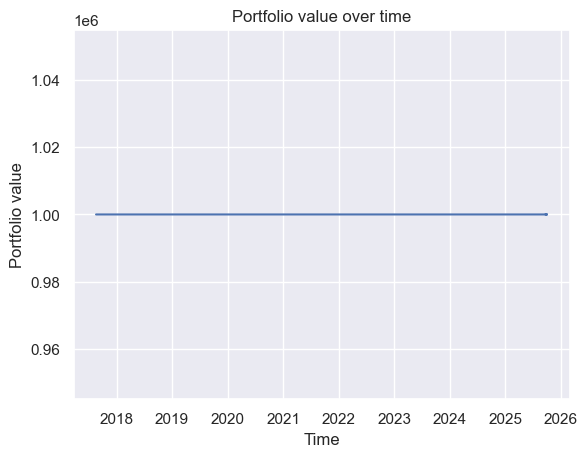

In [17]:
historic['Datetime'] = pd.to_datetime(historic['Datetime'])
historic = historic.set_index('Datetime')
historic['Portfolio Value'] = portfolio_value

plt.plot(historic.index, historic['Portfolio Value'])
plt.title('Portfolio value over time')
plt.xlabel('Time')
plt.ylabel('Portfolio value')
plt.show()

In [18]:
cash, portfolio_value[-1]

(1000000.0, 1000000.0)

In [19]:
def split(data: pd.DataFrame):
    train_size = int(len(data) * 0.6)
    test_size = int(len(data) * 0.2)

    train = data[:train_size]
    test = data[train_size:train_size + test_size]
    validation = data[train_size + test_size:]

    return train, test, validation

In [20]:
train, test, validation = split(data)
print(len(train), len(test), len(validation))

42496 14165 14166


In [21]:
train

,Unix,Datetime,Symbol,Open,High,Low,Close,Volume BTC,Volume USDT,tradecount,rsi
0,1.502940e+12,2017-08-17 04:00:00,BTCUSDT,4261.48,4313.62,4261.32,4308.83,47.181009,2.023661e+05,171,NaN
1,1.502950e+12,2017-08-17 05:00:00,BTCUSDT,4308.83,4328.69,4291.37,4315.32,23.234916,1.003048e+05,102,NaN
2,1.502950e+12,2017-08-17 06:00:00,BTCUSDT,4330.29,4345.45,4309.37,4324.35,7.229691,3.128231e+04,36,NaN
3,1.502950e+12,2017-08-17 07:00:00,BTCUSDT,4316.62,4349.99,4287.41,4349.99,4.443249,1.924106e+04,25,NaN
4,1.502960e+12,2017-08-17 08:00:00,BTCUSDT,4333.32,4377.85,4333.32,4360.69,0.972807,4.239504e+03,28,NaN
...,...,...,...,...,...,...,...,...,...,...,...
42491,1.656360e+12,2022-06-27 21:00:00,BTCUSDT,20913.57,20916.90,20783.15,20803.24,1093.614420,2.281656e+07,26735,45.566235
42492,1.656370e+12,2022-06-27 22:00:00,BTCUSDT,20803.25,20950.00,20762.80,20814.42,2552.767290,5.323287e+07,41271,45.737330
42493,1.656370e+12,2022-06-27 23:00:00,BTCUSDT,20814.42,20887.99,20680.00,20742.56,1915.178700,3.980011e+07,31550,44.808251
42494,1.656370e+12,2022-06-28 00:00:00,BTCUSDT,20742.57,20873.82,20684.00,20770.50,2620.370960,5.444156e+07,40482,45.252033


In [22]:
test

,Unix,Datetime,Symbol,Open,High,Low,Close,Volume BTC,Volume USDT,tradecount,rsi
42496,1.656380e+12,2022-06-28 02:00:00,BTCUSDT,20619.44,20684.39,20510.00,20640.98,3109.11374,64045339.30,47511,43.671307
42497,1.656390e+12,2022-06-28 03:00:00,BTCUSDT,20640.99,20758.16,20630.98,20735.03,1658.46245,34318757.95,30968,45.196821
42498,1.656390e+12,2022-06-28 04:00:00,BTCUSDT,20735.03,20795.09,20703.30,20771.57,1386.02065,28761410.08,25449,45.782309
42499,1.656390e+12,2022-06-28 05:00:00,BTCUSDT,20771.58,20829.10,20735.42,20741.30,1466.51374,30479544.85,25900,45.370204
42500,1.656400e+12,2022-06-28 06:00:00,BTCUSDT,20741.29,20900.00,20741.29,20862.65,1860.47094,38779664.51,35015,47.321192
...,...,...,...,...,...,...,...,...,...,...,...
56656,1.707360e+12,2024-02-08 03:00:00,BTCUSDT,44648.33,44727.42,44534.00,44540.99,1587.88976,70876812.50,52995,64.813867
56657,1.707360e+12,2024-02-08 04:00:00,BTCUSDT,44540.98,44605.00,44480.53,44489.90,806.92713,35947314.68,43600,64.048671
56658,1.707370e+12,2024-02-08 05:00:00,BTCUSDT,44489.89,44633.78,44489.89,44552.90,1056.72544,47095692.12,42373,64.577925
56659,1.707370e+12,2024-02-08 06:00:00,BTCUSDT,44552.89,44576.00,44450.00,44463.99,805.47228,35850869.77,49836,63.229703


In [23]:
validation

,Unix,Datetime,Symbol,Open,High,Low,Close,Volume BTC,Volume USDT,tradecount,rsi
56661,1.707380e+12,2024-02-08 08:00:00,BTCUSDT,44513.25,44744.00,44513.24,44718.33,1350.57478,6.031290e+07,55669,65.395766
56662,1.707380e+12,2024-02-08 09:00:00,BTCUSDT,44718.33,44788.01,44612.66,44692.81,1179.72665,5.273086e+07,60984,64.999494
56663,1.707390e+12,2024-02-08 10:00:00,BTCUSDT,44692.82,44850.00,44686.61,44828.27,1663.73936,7.451093e+07,79476,66.117963
56664,1.707390e+12,2024-02-08 11:00:00,BTCUSDT,44828.26,44885.00,44685.89,44698.97,1664.23633,7.454380e+07,90646,64.110950
56665,1.707390e+12,2024-02-08 12:00:00,BTCUSDT,44698.97,44841.10,44606.00,44689.20,1322.97171,5.917232e+07,53368,63.960387
...,...,...,...,...,...,...,...,...,...,...,...
70822,1.758570e+12,2025-09-22 19:00:00,BTCUSDT,112429.12,112600.87,111936.40,112122.90,1307.37365,1.467768e+08,126232,33.125299
70823,1.758570e+12,2025-09-22 20:00:00,BTCUSDT,112122.90,112977.41,111975.28,112781.88,596.84005,6.707508e+07,93553,38.378693
70824,1.758570e+12,2025-09-22 21:00:00,BTCUSDT,112781.87,112970.00,112602.79,112969.99,293.31156,3.307493e+07,42931,39.764964
70825,1.758580e+12,2025-09-22 22:00:00,BTCUSDT,112969.99,112970.00,112594.33,112643.25,289.60715,3.264691e+07,42836,38.231716


In [24]:
data['Datetime'].value_counts()

Datetime
2025-10-03 00:00:00    597
2025-03-04 01:00:00      2
2025-03-02 20:00:00      2
2025-03-02 12:00:00      2
2025-03-02 13:00:00      2
                      ... 
2020-05-12 06:00:00      1
2020-05-12 07:00:00      1
2020-05-12 08:00:00      1
2020-05-12 09:00:00      1
2025-09-22 23:00:00      1
Name: count, Length: 69682, dtype: int64

In [25]:
data[data['Datetime'] == '2025-03-04 01:00:00']

,Unix,Datetime,Symbol,Open,High,Low,Close,Volume BTC,Volume USDT,tradecount,rsi
66336,1.741050e+12,2025-03-04 01:00:00,BTCUSDT,86046.43,86196.0,82641.51,83380.55,5790.28933,4.868793e+08,868400,34.254595
66337,1.741050e+15,2025-03-04 01:00:00,BTCUSDT,86046.43,86196.0,82641.51,83380.55,5790.28933,4.868793e+08,868400,34.254595
